In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.utils import load_cleaned_data, compute_metrics, load_config, plot_confusion_matrix, metrics, apply_oversampling, store_metrics
from src.weighted_ensemble_predict import weighted_ensemble_predict
from transformers import (
    XLMRobertaTokenizerFast, 
    XLMRobertaForSequenceClassification,
    XLMRobertaConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    set_seed,
    )
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datasets import Dataset as HFDataset


In [ ]:
run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_id = f"run_{run_timestamp}"
config = load_config("../cfg/xlm_roberta.json")

# Set seeds
torch.backends.cudnn.deterministic = True
set_seed(config["seed"]) # Transformers

data = load_cleaned_data(config["data"]["preprocessed_data_path"])
X = data["full_text"]
y = data["label"]

print(f"Total samples: {len(data)}")
print(f"Label distribution: {y.value_counts().to_dict()}")

print("\nSample article (non-hyperpartisan):")
print(X[y == 0].iloc[0][:200] + "...")
print("\nSample article (hyperpartisan):")
print(X[y == 1].iloc[0][:200] + "...")



Total samples: 645
Label distribution: {0: 407, 1: 238}

Sample article (non-hyperpartisan):
It's 1968 All Over Again. Almost a half-century ago, in 1968, the United States seemed to be falling apart. The Vietnam War, a bitter and close presidential election, antiwar protests, racial riots, p...

Sample article (hyperpartisan):
Kucinich: Reclaiming the money power. Money ( Image by 401(K) 2013 ) Permission Details DMCA No Pill Can Stop Tinnitus, But This 1 Weird Trick Can The walls are closing in on Congress. Terrifying wall...


In [13]:
# Set up model name and tokenizer from config
model_name = config["model"]["base_model"]
tokenizer = XLMRobertaTokenizerFast.from_pretrained(model_name)

# Print the number of articles with more than 512 tokens
def count_tokens(article):
    return len(tokenizer(article)["input_ids"])
long_articles = X[X.apply(count_tokens) > 512]
print(f"Number of articles with more than 512 tokens: {len(long_articles)}")

# Set up XLM-RoBERTa configuration from config
xlm_roberta_config = XLMRobertaConfig.from_pretrained(model_name)
xlm_roberta_config.classifier_dropout = config["model"]["classifier_dropout"]
xlm_roberta_config.num_labels = config["model"]["num_labels"]


def tokenize_texts(texts, labels, tokenizer, is_training=True):
    """Tokenize texts with sliding window only during training"""
    dataset_dict = {"text": texts.tolist(), "label": labels.tolist()}
    dataset = HFDataset.from_dict(dataset_dict)
    
    def tokenize_function(examples):
        # Only use sliding window during training
        if is_training:
            tokenized = tokenizer(
                examples["text"],
                padding=config["tokenizer"]["padding"],
                truncation=config["tokenizer"]["truncation"],
                max_length=config["data"]["max_length"],
                add_special_tokens=config["tokenizer"]["add_special_tokens"],
                return_tensors=config["tokenizer"]["return_tensors"],
                stride=config["tokenizer"]["stride"],
                return_overflowing_tokens=config["tokenizer"]["return_overflowing_tokens"],
            )
            
            # Map labels to chunks
            if "overflow_to_sample_mapping" in tokenized:
                sample_map = tokenized.pop("overflow_to_sample_mapping")
                labels = []
                for i in sample_map:
                    labels.append(examples["label"][i])
                return {**tokenized, "label": labels}
        else:
            # Standard tokenization for prediction
            return tokenizer(
                examples["text"],
                padding=config["tokenizer"]["padding"],
                truncation=config["tokenizer"]["truncation"],
                max_length=config["data"]["max_length"],
                add_special_tokens=config["tokenizer"]["add_special_tokens"],
                return_tensors=config["tokenizer"]["return_tensors"]
            )
        
        return tokenized
    
    # Map tokenization function
    tokenized_dataset = dataset.map(
        tokenize_function, 
        batched=config["tokenizer"]["batch_process"], 
        remove_columns=config["tokenizer"]["remove_columns"]
    )
    
    # Format for PyTorch
    tokenized_dataset.set_format(
        type=config["tokenizer"]["format_type"], 
        columns=config["tokenizer"]["format_columns"]
    )
    
    return tokenized_dataset

Token indices sequence length is longer than the specified maximum sequence length for this model (2031 > 512). Running this sequence through the model will result in indexing errors


Number of articles with more than 512 tokens: 376


In [14]:
# Set up device
device = None
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# Cross-validation setup from config
n_splits = config["cross_validation"]["n_splits"]
kf = StratifiedKFold(
    n_splits=n_splits, 
    shuffle=config["cross_validation"]["shuffle"], 
    random_state=config["cross_validation"]["random_state"]
)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n=== Fold {fold+1}/{n_splits} ===")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Apply class balancing if configured
    if config["class_balancing"]["use_balancing"]:
        X_train_fold, y_train_fold = apply_oversampling(
            X_train_fold, 
            y_train_fold, 
            config["class_balancing"]["oversampling_method"]
        )
    
    # Tokenize datasets
    train_dataset = tokenize_texts(
        X_train_fold, 
        y_train_fold, 
        tokenizer,
        is_training=True
    )
    val_dataset = tokenize_texts(
        X_val_fold, 
        y_val_fold, 
        tokenizer, 
        is_training=False
    )
    
    # Create a fresh model for this fold
    model = XLMRobertaForSequenceClassification.from_pretrained(
        model_name,
        config=xlm_roberta_config
    ).to(device)
    
    # Create data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    # Training arguments from config
    training_args = TrainingArguments(
        output_dir=f"{config["training"]["output_dir"]}/{run_id}/xlm_roberta_fold_{fold+1}",
        learning_rate=config["training"]["learning_rate"],
        per_device_train_batch_size=config["training"]["batch_size"],
        per_device_eval_batch_size=config["training"]["eval_batch_size"],
        num_train_epochs=config["training"]["epochs"],
        weight_decay=config["training"]["weight_decay"],
        evaluation_strategy=config["training"]["evaluation_strategy"],
        save_strategy=config["training"]["save_strategy"],
        load_best_model_at_end=config["training"]["load_best_model_at_end"],
        metric_for_best_model=config["training"]["metric_for_best_model"],
        save_total_limit=config["training"]["save_total_limit"],
        fp16=torch.cuda.is_available(),
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=config["training"]["early_stopping_patience"])
            ]
    )
    
    trainer.train()
    results = trainer.evaluate()
    fold_results.append(results)
    
    
    # Clear memory
    del model, trainer
    torch.cuda.empty_cache()


=== Fold 1/5 ===


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/tinnitussen/DAT550/DAT550-2025---Hyperpartisan-News-Detection-/.venv/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_107911/1295357872.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Precision,Recall,F1
1,No log,0.607185,0.500000,0.000000,0.000000,0.000000
2,No log,0.518945,0.500000,0.000000,0.000000,0.000000


KeyboardInterrupt: 

In [ ]:
model_base_path = config['training']['output_dir']
results_path = f"{model_base_path}/{run_id}/fold_metrics.json"

# Save all fold metrics in a single JSON file, keeping the existing structure
with open(results_path, 'w') as f:
    json.dump(fold_results, f, indent=4)

print(f"Saved metrics for all folds to {results_path}")

[{'eval_loss': 0.3437827527523041, 'eval_balanced_accuracy': 0.8649691358024691, 'eval_precision': 0.8837209302325582, 'eval_recall': 0.7916666666666666, 'eval_f1': 0.8351648351648352, 'eval_runtime': 0.7189, 'eval_samples_per_second': 179.443, 'eval_steps_per_second': 23.648, 'epoch': 7.0}, {'eval_loss': 0.9106898307800293, 'eval_balanced_accuracy': 0.8198302469135803, 'eval_precision': 0.7358490566037735, 'eval_recall': 0.8125, 'eval_f1': 0.7722772277227723, 'eval_runtime': 0.7583, 'eval_samples_per_second': 170.122, 'eval_steps_per_second': 22.419, 'epoch': 11.0}, {'eval_loss': 0.906911313533783, 'eval_balanced_accuracy': 0.8198302469135803, 'eval_precision': 0.7358490566037735, 'eval_recall': 0.8125, 'eval_f1': 0.7722772277227723, 'eval_runtime': 0.9199, 'eval_samples_per_second': 140.239, 'eval_steps_per_second': 18.481, 'epoch': 11.0}, {'eval_loss': 0.8034510612487793, 'eval_balanced_accuracy': 0.7871043072132848, 'eval_precision': 0.8157894736842105, 'eval_recall': 0.65957446808

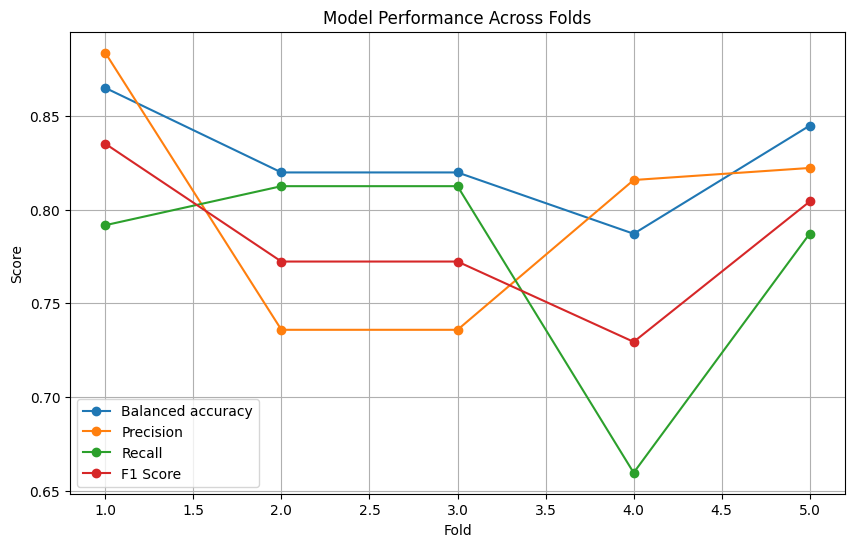

In [ ]:
# Analyze cross-validation results
accuracies = [result["eval_balanced_accuracy"] for result in fold_results]
precisions = [result["eval_precision"] for result in fold_results]
recalls = [result["eval_recall"] for result in fold_results]
f1_scores = [result["eval_f1"] for result in fold_results]

print("\nCross-validation summary:")
print(f"Balanced accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# Visualize metrics across folds
plt.figure(figsize=(10, 6))
fold_nums = list(range(1, n_splits + 1))
plt.plot(fold_nums, accuracies, "o-", label="Balanced accuracy")
plt.plot(fold_nums, precisions, "o-", label="Precision")
plt.plot(fold_nums, recalls, "o-", label="Recall")
plt.plot(fold_nums, f1_scores, "o-", label="F1 Score")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Model Performance Across Folds")
plt.legend()
plt.grid(True)
plt.show()


Ensemble Model Evaluation:
Accuracy: 0.86
Balanced Accuracy: 0.86
Precision: 0.88
Recall: 0.83
F1: 0.86
AUC: 0.92


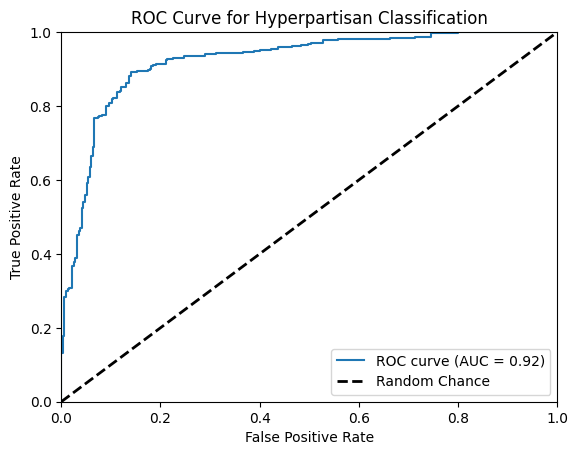

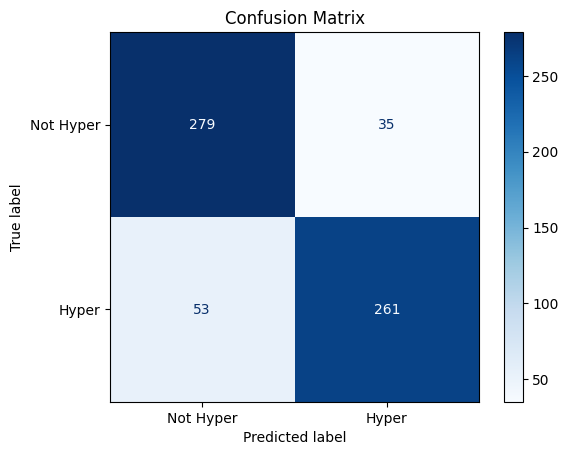

In [ ]:
# Ensemble predictions on the test set for robustness
fold_metrics = [result['eval_f1'] for result in fold_results]

fold_models = []
for fold in range(config["cross_validation"]["n_splits"]):
    model_base_path = config['training']['output_dir']
    model_path = f"{model_base_path}/{run_id}/xlm_roberta_fold_{fold+1}"
    model = XLMRobertaForSequenceClassification.from_pretrained(
        model_path
    ).to(device)
    model.eval()  # Set to evaluation mode
    fold_models.append(model)


test_data = load_cleaned_data(config["data"]["test_data_path"])
X_test = test_data["full_text"]
y_test = test_data["label"]
# Get predictions for all test samples
y_pred = []
y_pred_proba = []

for text in X_test:
    # Tokenize input
    inputs = tokenizer(
        text,
        max_length=config["data"]["max_length"],
        truncation=config["tokenizer"]["truncation"],
        padding=config["tokenizer"]["padding"],
        add_special_tokens=config["tokenizer"]["add_special_tokens"],
        return_tensors=config["tokenizer"]["return_tensors"]
    ).to(device)
    
    # Get ensemble prediction
    weighted_probs = weighted_ensemble_predict(inputs, fold_models, fold_metrics, device)
    
    # Extract prediction and confidence
    pred_label = torch.argmax(weighted_probs, dim=1).item()
    confidence = weighted_probs[0][1].item()  # Probability of class 1 (hyperpartisan)
    
    y_pred.append(pred_label)
    y_pred_proba.append(confidence)

# Convert to numpy arrays for the metrics function
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("\nEnsemble Model Evaluation:")
metrics(y_test, y_pred, y_pred_proba)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
results_list = []
store_metrics(
    results_list=results_list,
    model_name="XLM-RoBERTa",
    setup_label="WeightedEnsemble+SlidingWindow",
    y_test=y_test,
    y_pred=y_pred,
    y_pred_proba=y_pred_proba
)

results_df = pd.DataFrame(results_list)

hyperparams = {
    # Model parameters
    "base_model": config["model"]["base_model"],
    "classifier_dropout": config["model"]["classifier_dropout"],
    
    # Training parameters
    "learning_rate": config["training"]["learning_rate"],
    "batch_size": config["training"]["batch_size"],
    "eval_batch_size": config["training"]["eval_batch_size"],
    "epochs": config["training"]["epochs"],
    "weight_decay": config["training"]["weight_decay"],
    "evaluation_strategy": config["training"]["evaluation_strategy"],
    "save_strategy": config["training"]["save_strategy"],
    "load_best_model_at_end": config["training"]["load_best_model_at_end"],
    "metric_for_best_model": config["training"]["metric_for_best_model"],
    "save_total_limit": config["training"]["save_total_limit"],
    "early_stopping_patience": config["training"]["early_stopping_patience"],
    "use_fp16": config["training"]["use_fp16"],
    
    # Cross-validation settings
    "n_splits": config["cross_validation"]["n_splits"],
    "shuffle": config["cross_validation"]["shuffle"],
    
    # Data parameters
    "max_length": config["data"]["max_length"],
    "test_size": config["data"]["test_size"],
    "data_random_state": config["data"]["random_state"],
    
    # Class balancing
    "use_balancing": config["class_balancing"]["use_balancing"],
    "balancing_method": config["class_balancing"]["method"],
    
    # Tokenizer settings
    "padding": config["tokenizer"]["padding"],
    "truncation": config["tokenizer"]["truncation"],
    "add_special_tokens": config["tokenizer"]["add_special_tokens"],
    "batch_process": config["tokenizer"]["batch_process"],
    "stride": config["tokenizer"]["stride"],
    "return_overflowing_tokens": config["tokenizer"]["return_overflowing_tokens"],
}

# Add all hyperparameters as columns in one operation
for param_name, param_value in hyperparams.items():
    results_df[param_name] = param_value

display(results_df)

try:
    existing_df = pd.read_csv("../results/byarticle_advanced_results.csv")
    combined_df = pd.concat([existing_df, results_df], ignore_index=True)
    combined_df.to_csv("../results/byarticle_advanced_results.csv", index=False)
except FileNotFoundError:
    results_df.to_csv("../results/byarticle_advanced_results.csv", index=False)

,Model,Setup,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score,AUC,base_model,classifier_dropout,...,test_size,data_random_state,use_balancing,balancing_method,padding,truncation,add_special_tokens,batch_process,stride,return_overflowing_tokens
0,XLM-RoBERTa,WeightedEnsemble+SlidingWindow,0.86,0.86,0.882,0.831,0.856,0.921,xlm-roberta-base,0.2,...,0.2,0,False,oversample,max_length,True,True,True,128,False
